<a href="https://colab.research.google.com/github/Ronald2328/FacialRecognition/blob/main/ReconocimientoFacial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyngrok

In [ ]:
# Importar el paquete pyngrok para crear túneles seguros a través de ngrok
from pyngrok import ngrok
# Importar funciones y clases para mostrar contenido interactivo en el cuaderno de Jupyter
from IPython.display import display, Javascript, Image
# Importar función para ejecutar código JavaScript en el navegador desde el cuaderno de Colab
from google.colab.output import eval_js
# Importar funciones para codificar y decodificar datos en base64
from base64 import b64decode, b64encode
# Importar la biblioteca OpenCV para procesamiento de imágenes
import cv2
# Importar la biblioteca Pillow para procesamiento de imágenes
import PIL
# Importar el módulo io para trabajar con flujos de entrada y salida
import io

#=========================================
import html
import time
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from google.colab.patches import cv2_imshow

In [ ]:
#Carpeta donde guardaremos las imagenes capturadas
directorio = 'C:\\Users\\Ronaldo Olivares\\Desktop\\ReconocimientoFacial\\Image'

In [ ]:
# Función para convertir el objeto JavaScript en una imagen OpenCV
def js_to_image(js_reply):
  """
  Parámetros:
          js_reply: Objeto JavaScript que contiene la imagen de la cámara web
  Devuelve:
          img: Imagen OpenCV en formato BGR
  """
  # Decodificar la imagen base64
  image_bytes = b64decode(js_reply.split(',')[1])
  # Convertir bytes en un arreglo numpy
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # Decodificar el arreglo numpy en una imagen OpenCV en formato BGR
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# Función para convertir el cuadro delimitador de un rectángulo OpenCV en una cadena de bytes base64 para superponer en la transmisión de video
def bbox_to_bytes(bbox_array):
  """
  Parámetros:
          bbox_array: Arreglo numpy (píxeles) que contiene el rectángulo a superponer en la transmisión de video.
  Devuelve:
        bytes: Cadena de bytes de imagen base64
  """
  # Convertir el arreglo en una imagen PIL
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # Formatear el rectángulo en png para su retorno
  bbox_PIL.save(iobuf, format='png')
  # Formatear la cadena de retorno
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# Cargar el clasificador de cascada para la detección de rostros
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
# JavaScript para crear adecuadamente nuestra transmisión de video en vivo utilizando nuestra cámara web como entrada
def video_stream():
  js = Javascript('''
    // Definición de variables para elementos de la interfaz de usuario y manipulación de datos
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    // Variables para la resolución pendiente y apagado
    var pendingResolve = null;
    var shutdown = false;

    // Función para eliminar los elementos de la interfaz de usuario
    function removeDom() {
       stream.getVideoTracks()[0].stop(); // Detener la transmisión de video
       video.remove(); // Eliminar el elemento de video
       div.remove(); // Eliminar el contenedor
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    // Función para el bucle de animación para actualizar la imagen capturada
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame); // Solicitar el próximo cuadro de animación
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480); // Dibujar la imagen capturada en el lienzo
          result = captureCanvas.toDataURL('image/jpeg', 0.8); // Convertir la imagen en formato base64
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result); // Resolver la promesa con la imagen capturada
      }
    }

    // Función asincrónica para crear la interfaz de usuario
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div'); // Crear un nuevo div para la interfaz de usuario
      div.style.border = '2px solid black'; // Estilo de borde
      div.style.padding = '3px'; // Estilo de relleno
      div.style.width = '100%'; // Ancho
      div.style.maxWidth = '600px'; // Ancho máximo
      document.body.appendChild(div); // Agregar el div al cuerpo del documento

      const modelOut = document.createElement('div'); // Crear un nuevo div para la salida del modelo
      modelOut.innerHTML = "<span>Estado:</span>"; // Etiqueta de estado
      labelElement = document.createElement('span'); // Crear un nuevo span para mostrar el estado
      labelElement.innerText = 'Sin datos'; // Texto inicial
      labelElement.style.fontWeight = 'bold'; // Estilo de fuente
      modelOut.appendChild(labelElement); // Agregar el span al div de salida del modelo
      div.appendChild(modelOut); // Agregar el div de salida del modelo al div principal

      video = document.createElement('video'); // Crear un nuevo elemento de video
      video.style.display = 'block'; // Estilo de visualización
      video.width = div.clientWidth - 6; // Ancho del video
      video.setAttribute('playsinline', ''); // Configuración para reproducción en línea
      video.onclick = () => { shutdown = true; }; // Manejador de eventos de clic para detener la demostración
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}}); // Obtener la transmisión de video desde la cámara
      div.appendChild(video); // Agregar el video al div principal

      imgElement = document.createElement('img'); // Crear un nuevo elemento de imagen
      imgElement.style.position = 'absolute'; // Estilo de posición
      imgElement.style.zIndex = 1; // Índice de apilamiento
      imgElement.onclick = () => { shutdown = true; }; // Manejador de eventos de clic para detener la demostración
      div.appendChild(imgElement); // Agregar la imagen al div principal

      const instruction = document.createElement('div'); // Crear un nuevo div para las instrucciones
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'Cuando termines, haz clic aquí o en el video para detener esta demostración</span>'; // Texto de las instrucciones
      div.appendChild(instruction); // Agregar las instrucciones al div principal
      instruction.onclick = () => { shutdown = true; }; // Manejador de eventos de clic para detener la demostración

      video.srcObject = stream; // Asignar la transmisión de video al elemento de video
      await video.play(); // Iniciar la reproducción del video

      captureCanvas = document.createElement('canvas'); // Crear un nuevo lienzo para captura
      captureCanvas.width = 640; // Ancho del lienzo
      captureCanvas.height = 480; // Alto del lienzo
      window.requestAnimationFrame(onAnimationFrame); // Solicitar el primer cuadro de animación

      return stream;
    }
    // Función asincrónica para transmitir el fotograma y manejar la interfaz de usuario
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom(); // Eliminar los elementos de la interfaz de usuario si se activa el apagado
        shutdown = false; // Restablecer el indicador de apagado
        return '';
      }

      var preCreate = Date.now(); // Registro de tiempo antes de crear la interfaz de usuario
      stream = await createDom(); // Crear la interfaz de usuario
      var preShow = Date.now(); // Registro de tiempo antes de mostrar la imagen y actualizar la etiqueta

      if (label != "") {
        labelElement.innerHTML = label; // Actualizar la etiqueta de estado
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0]; // Obtener el rectángulo del video
        imgElement.style.top = videoRect.top + "px"; // Establecer la posición superior de la imagen
        imgElement.style.left = videoRect.left + "px"; // Establecer la posición izquierda de la imagen
        imgElement.style.width = videoRect.width + "px"; // Establecer el ancho de la imagen
        imgElement.style.height = videoRect.height + "px"; // Establecer la altura de la imagen
        imgElement.src = imgData; // Asignar la imagen base64 al elemento de imagen
      }

      var preCapture = Date.now(); // Registro de tiempo antes de capturar la imagen
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve; // Resolver la promesa con la imagen capturada
      });
      shutdown = false; // Restablecer el indicador de apagado

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result}; // Devolver información sobre los tiempos de ejecución y la imagen capturada
    }
    ''')

  display(js)

# Función para obtener el fotograma de video y actualizar la interfaz de usuario
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox)) # Llamar a la función JavaScript con la etiqueta y el cuadro delimitador
  return data

In [ ]:
def guardar_imagen(nombre_directorio, nombre_imagen, frame):
    # Mostrar la imagen capturada
    cv2_imshow(frame)

    # Guardar la imagen en el directorio especificado con el nombre deseado
    ruta_imagen = os.path.join(nombre_directorio, nombre_imagen)
    cv2.imwrite(ruta_imagen, frame)
    print(f'Imagen guardada como {nombre_imagen} en {nombre_directorio}')


In [ ]:
# Comenzar la transmisión de video desde la cámara web
video_stream()
# Etiqueta para el video
label_html = 'Capturando...'
# Inicializar cuadro delimitador en vacío
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # Convertir la respuesta JS a una imagen de OpenCV
    img = js_to_image(js_reply["img"])

    # Crear superposición transparente para el cuadro delimitador
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # Imagen en escala de grises para detección de rostros
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Obtener coordenadas de la región facial
    faces = face_cascade.detectMultiScale(gray)
    # Obtener cuadro delimitador facial para superposición
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # Convertir la superposición del cuadro delimitador en bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # Actualizar bbox para que el siguiente fotograma obtenga una nueva superposición
    bbox = bbox_bytes

print('Imagen Capturada')

<IPython.core.display.Javascript object>

Imagen Capturada


Ingrese el nombre para la imagen (incluya la extensión .jpg): a.png


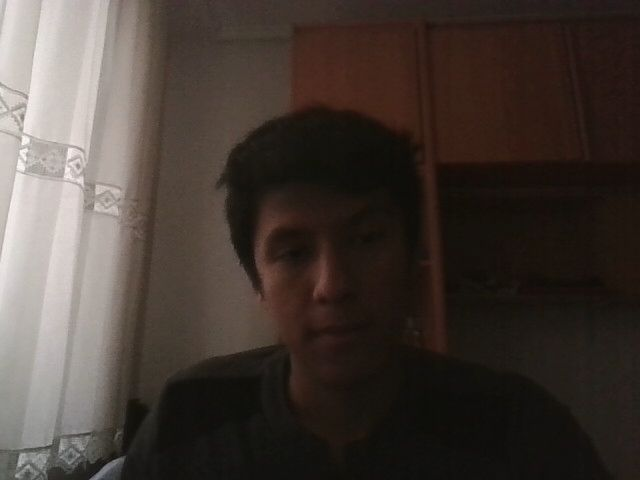

Imagen guardada como a.png en C:\Users\Ronaldo Olivares\Desktop\ReconocimientoFacial\Image


In [ ]:
# Pedir al usuario el nombre de la imagen
nombre_imagen = input('Ingrese el nombre para la imagen (incluya la extensión .jpg): ')

# Llamar a la función para capturar y guardar la imagen
guardar_imagen(directorio, nombre_imagen,img)

In [ ]:
def listar_imagenes_en_directorio(directorio):
    # Obtener la lista de archivos en el directorio
    archivos = os.listdir(directorio)

    # Filtrar los archivos para que solo sean imágenes (extensiones jpg y png)
    imagenes = [archivo for archivo in archivos if archivo.endswith('.jpg') or archivo.endswith('.png')]

    if len(imagenes) == 0:
        print('No se encontraron imágenes en el directorio especificado.')
    else:
        print('Imágenes encontradas en el directorio:')
        for imagen in imagenes:
            print(imagen)

In [ ]:
# Llamar a la función para listar las imágenes en el directorio especificado
listar_imagenes_en_directorio(directorio)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Ronaldo Olivares\\Desktop\\ReconocimientoFacial\\Image'